In [40]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
#import data
from biom import load_table
from gneiss.util import match
#DEICODE
from DEICODE import untangle
#transforms 
from skbio.stats.composition import clr,ilr,centralize
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#else
#regression
from gneiss.regression import ols
from gneiss.composition import ilr_transform
from gneiss.cluster import correlation_linkage

%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

 Sponges (case study)

 A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera

 P.I.  Torsten Thomas (University of New South Wales)
 [Data and Source](https://qiita.ucsd.edu/study/description/10346)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [2]:
from biom import load_table
from gneiss.util import match

# import observation data
in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
table = load_table(in_biom)
read_filter = lambda val, id_, md: sum(val) > 100
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
#mappingdf.drop(['Color Description','Anonymized Name'],axis=1,inplace=True)
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)

Next we will run supervised machine learning this will help us identify biologically relevant trends in the data quickly

In [70]:
# complete will determine if you do completion (iteration is the number of iterations for the completion)
X_recovered=untangle.complete_matrix(otutabledf.as_matrix().copy(),rank=8,iteration=40)
X_recovered=pd.DataFrame(X_recovered,columns=otutabledf.columns,index=otutabledf.index)

In [35]:
# This command will do machine leanring on your otu table and mapping file. It ouputs your scores
# The main input is just the otu table and the mapping data. 
spongescores,_=untangle.machine_learning(X_recovered.T,mappingdf,addtofilter=['adult'],mean_count=10)

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. For example here we see that life stage correlates the best with taxonomic trends.

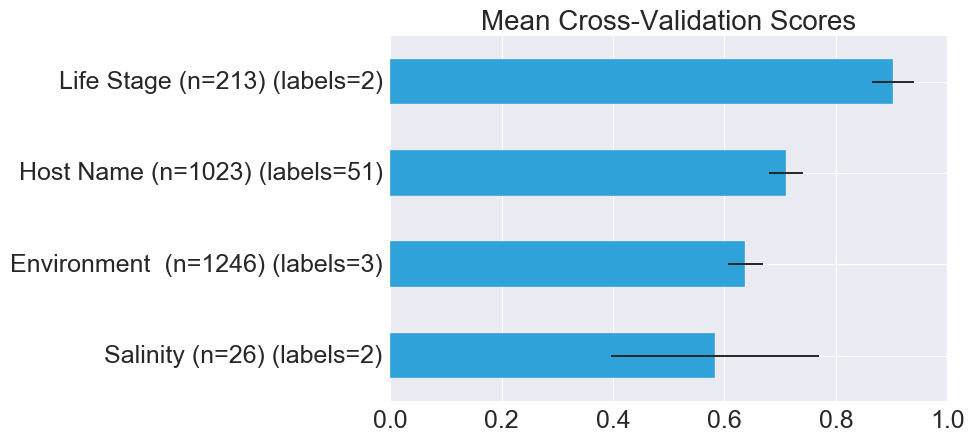

In [36]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
spongescores.sort_values(['Mean Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few

spongescores_=spongescores[spongescores['Mean Matrix Completion (RF)']>.50]
spongescores_['Mean Matrix Completion (RF)'].plot(kind='barh',xerr=np.array(spongescores_['std Matrix Completion (RF)'])
                                                 ,fontsize=18,xlim=(0,1),legend=False,ax=ax1)
ax1.set_ylabel('')
plt.title('Mean Cross-Validation Scores',fontsize=20)
plt.show()



Now we can extract OTUs (features) that separate sponges across life stages.

 Now that we know from the cross-validation scores that life stage is an important category we would like to find out what pattern of OTUs best explain this variation.  Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the sponge sample's life stage. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

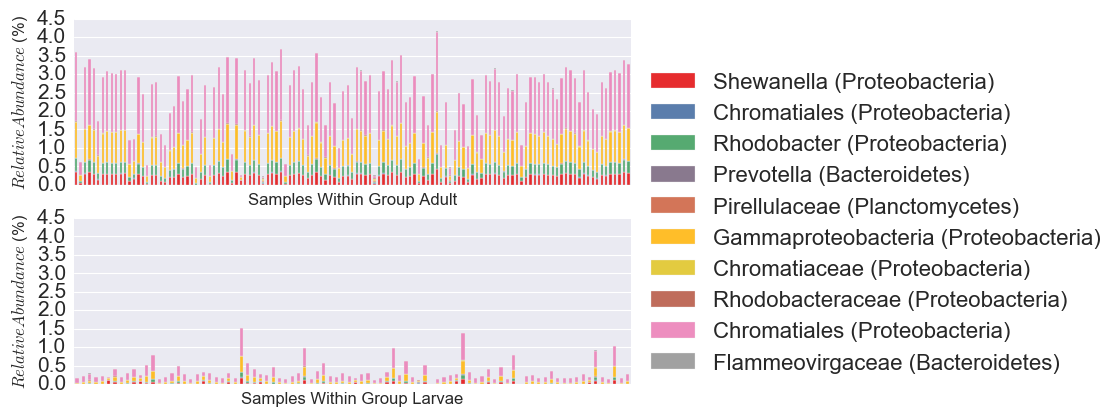

In [68]:
# get important features
niche='Life Stage'
n=10# this will be the number of OTUs that are in the figure 
filter_names=['Unknown','adult'] # this is a list of labels in the mapping you would like removed such as Unknown or Not available

#cap values
X_recovered_=X_recovered.copy()
X_recovered_[X_recovered_<.1]=.1

# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=match(X_recovered_.T[X_recovered_.sum()>250].T
                         ,mappingdf[~mappingdf[niche].isin(['Unknown','adult'])])
important_otus=untangle.features_ml(sfotus.T,sfmappingdf,niche)

# plot
fig=untangle.feature_vis(sfotus,sfmappingdf.T,list(important_otus.index[:n]),niche,pd.DataFrame(taxonomy['taxonomy']))
plt.show()

 Here we find that the OTUs that best differentiate the samples between adult sponges and larvae are mostly in the phylum Proteobacteria. We can see that the Proteobacteria Marinomonas and Oceanospirillaceae are more abundant in adult sponges, while the larvae sponges have a diverse group of Proteobacteria and Chloroflexi that differentiate them.

Now we can view this pattern directly in the OTU table using biclustering, first we will write a simple plotting script allowing us to compare between before and after matrix completion

In [15]:
# we will use this as our simple plotting function
def plot_compare(org_otudata,comp_otu,mapping,catvis,titleadd=['Before Matrix Completion ','After Matrix Completion '],hmax=6,fig_fontsize=18):
    
    #transform
    clr_org_otudata=pd.DataFrame(clr(org_otudata.as_matrix().copy()+1),
                                 columns=org_otudata.columns,index=org_otudata.index)
    clr_comp_otu=pd.DataFrame(clr(comp_otu.as_matrix().copy()),
                              columns=comp_otu.columns,index=comp_otu.index)
    biplots=[]
    for otudata,pcoaotu,title in zip([clr_org_otudata,clr_comp_otu],[org_otudata,comp_otu],titleadd):
    
        #biplot
        r=2
        biploto,datatmp=untangle.biplot(otudata.copy(),r)
        biplots.append([biploto,datatmp])
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 5)) 

        if title!='':
            fig.suptitle('%s '%(title),fontsize=fig_fontsize+4)

        sns.heatmap(otudata,xticklabels=False, yticklabels=False,robust=True,cmap='RdBu_r',ax=ax1)
        ax1.set_title('OTU Table\n',fontsize=fig_fontsize)    
        ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
        ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)

        sns.heatmap(biploto,xticklabels=False, yticklabels=False,robust=True,cmap='RdBu_r',ax=ax2)
        ax2.set_title('Spectral Coclustering \n',fontsize=fig_fontsize)    
        ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
        ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)
        
        pcaplot=pcoa(DistanceMatrix(pdist(pcoaotu.as_matrix().T,'braycurtis'),
                                    list(pcoaotu.columns))).samples[['PC1','PC2','PC3']]
        pcaplot[catvis]=list(mapping.T[catvis])
        for ((key, grp)) in pcaplot.groupby(catvis):
            ax3.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
        ax3.set_title('PCoA (bray-curtis) \n',fontsize=fig_fontsize)
        ax3.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
        ax3.set_xlabel('$PC-2$',fontsize=fig_fontsize-2)    

        plt.tight_layout()
        fig.subplots_adjust(top=.78)

    return biplots

Now we will perform PCoA and biclustering for the OTU table before and after matrix completion 

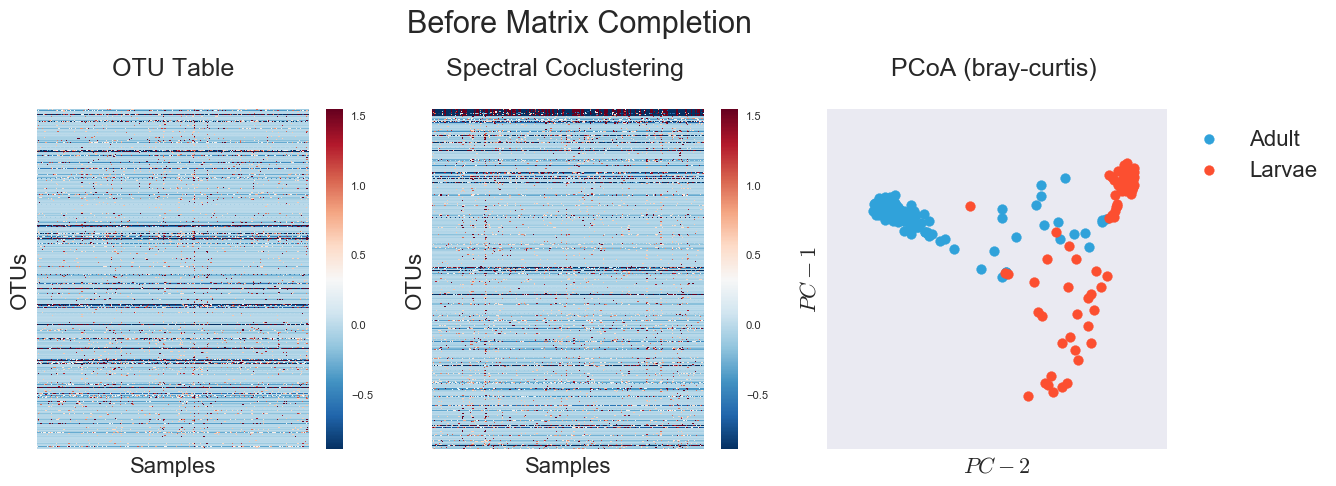

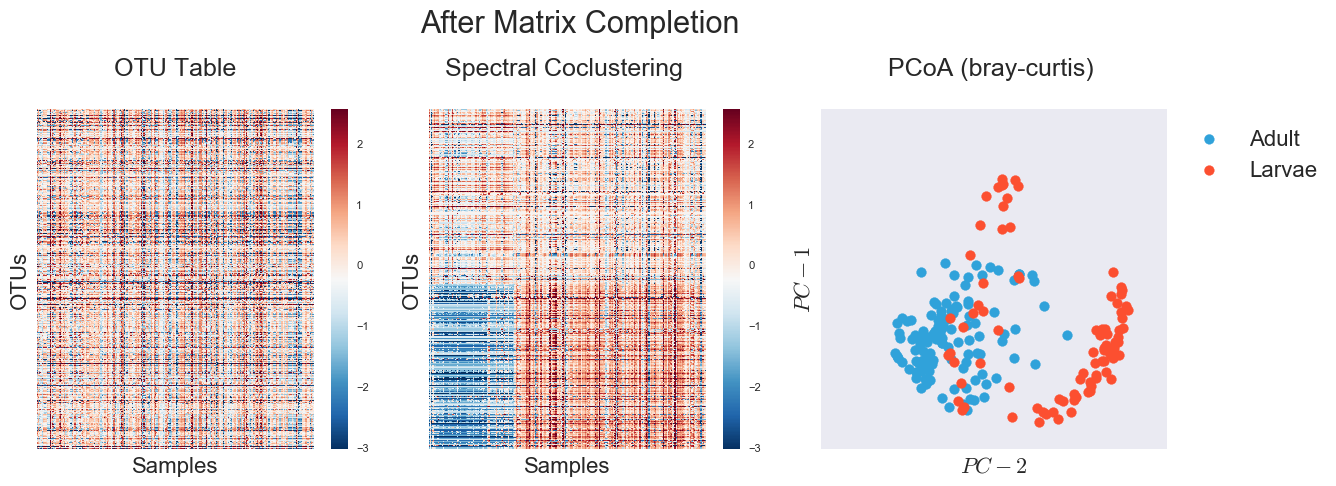

In [72]:
#match input
X_recovered_=X_recovered.copy()
X_recovered_[X_recovered_<.1]=.1
sp_otutabledf,sp_mappingdf=match(otutabledf,mappingdf[~mappingdf[niche].isin(['Unknown','adult'])])
X_recovered_,sp_mappingdf=match(X_recovered_,mappingdf[~mappingdf[niche].isin(['Unknown','adult'])])
#complete the matrix
sp_mappingdf.columns=['Collection_Timestamp', 'Country', 'Depth', 'Environment', 'Host_Name',
       'Host_ID', 'Latitude', 'Longitude', 'Processing_Lab ', 'pH',
       'Life_Stage', 'Temp ', 'Salinity']

#plot biplots comparison 
biplots=plot_compare(sp_otutabledf.T,X_recovered_.T,sfmappingdf.T,niche)
plt.show()

Finally, we can see that indeed we can sort the OTUs into the repective groups. This can be increibly power because you can start to vuew each cluster as community specfiic to different enviornments. 

In [66]:
#run without completion
formula='Salinity+Life_Stage+Host_Name+Environment+pH+Longitude+Temp'
tree = correlation_linkage(sp_otutabledf+1)
balances_org = ilr_transform(sp_otutabledf+1, tree=tree)
res_org = ols(table=balances_org, metadata=sp_mappingdf,formula=formula)
res_org.fit()
cv_opt = res_org.kfold(4)
#view results 
cv_opt

,model_mse,Rsquared,pred_mse
fold_0,23.076636,0.499915,8.068875
fold_1,22.683886,0.511711,8.718015
fold_2,20.923066,0.543640,10.346375
fold_3,23.477282,0.497616,7.640666


In [67]:
X_recovered_=X_recovered.copy()
X_recovered_[X_recovered_<1]=1
X_recovered_,recovered_mapping=match(X_recovered_,sp_mappingdf)

#run regression 
formula='Salinity+Life_Stage+Host_Name+Environment+pH+Longitude+Temp'
tree = correlation_linkage(X_recovered_)
balances_completed = ilr_transform(X_recovered_, tree=tree)
res_opt = ols(table=balances_completed, metadata=recovered_mapping,formula=formula)
res_opt.fit()
cv_opt = res_opt.kfold(4)
#view results 
cv_opt

,model_mse,Rsquared,pred_mse
fold_0,18.091067,0.438181,4.469078
fold_1,15.603948,0.482686,7.452053
fold_2,14.727641,0.511359,7.922514
fold_3,17.658057,0.448242,4.984232


[Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/infant_biom.ipynb)